## MPAA rating prediction

In [173]:
import pandas as pd
import numpy as np
import warnings
import re
import pickle
import seaborn as sns

%matplotlib inline
warnings.filterwarnings('ignore')

Import dataset :: using the rotten tomatoes dataset

In [174]:
dataset_df = pd.read_csv( './rtt_dataset/all_movie.csv' )
dataset_df = dataset_df[['Title', 'Rating', 'Description']]
dataset_df.columns = dataset_df.columns.str.strip()
dataset_df.head(4)

,Title,Rating,Description
0,The Mummy: Tomb of the Dragon Emperor,PG-13,The Fast and the Furious director Rob Cohen co...
1,The Masked Saint,PG-13,The journey of a professional wrestler who bec...
2,Spy Hard,PG-13,"Dead pan Leslie Nielsen stars as Dick Steele, ..."
3,Der Baader Meinhof Komplex (The Baader Meinhof...,R,Director Uli Edel teams with screenwriter Bern...


In [175]:
# finding unique mpaa rating in the dataset
dataset_df['Rating'].unique()

array(['PG-13 ', 'PG-13', 'R ', 'NR', 'PG', 'G', 'PG ', 'R', 'G ', 'NR ',
       'NC17', 'NC17 '], dtype=object)

In [176]:
# clean mpaa ratings
mpaa_fix = {
    'PG-13 ' : 'PG-13',
    'R ' : 'R',
    'PG ': 'PG',
    'G ' : 'G',
    'NR ': 'NR',
    'NC17 ': 'NC17'
}
for i, rating in dataset_df['Rating'].iteritems():
    if rating in mpaa_fix.keys():
        fix_val = mpaa_fix.get(rating)
        dataset_df.iloc[i]['Rating'] = fix_val
dataset_df['Rating'].unique()

array(['PG-13', 'R', 'NR', 'PG', 'G', 'NC17'], dtype=object)

In [177]:
# Clean the movie description
def clean_description( text_str ):
    text = re.sub('[^a-zA-Z]',  ' ', text_str)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

cleaned_desc = []
for i, description in dataset_df['Description'].iteritems():
    cleaned_desc.append( clean_description( str(description) ) )

dataset_df['cleanedDescr'] = cleaned_desc
dataset_df.head(4)

,Title,Rating,Description,cleanedDescr
0,The Mummy: Tomb of the Dragon Emperor,PG-13,The Fast and the Furious director Rob Cohen co...,The Fast and the Furious director Rob Cohen co...
1,The Masked Saint,PG-13,The journey of a professional wrestler who bec...,The journey of professional wrestler who becom...
2,Spy Hard,PG-13,"Dead pan Leslie Nielsen stars as Dick Steele, ...",Dead pan Leslie Nielsen stars as Dick Steele a...
3,Der Baader Meinhof Komplex (The Baader Meinhof...,R,Director Uli Edel teams with screenwriter Bern...,Director Uli Edel teams with screenwriter Bern...


In [178]:
pickle.dump(dataset_df, open('./data/dataset_df_cleaned_n_sample_exceptNC17BiD.pkl', 'wb'))

## Data Distribution

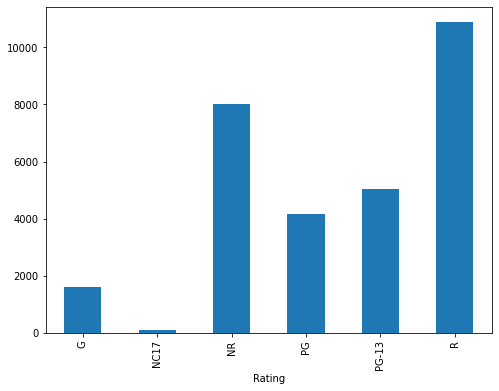

In [181]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
dataset_df.groupby('Rating')['cleanedDescr'].count().plot.bar(ylim=0)
plt.show()

In [182]:
## drop G, NC-17
dataset_df = dataset_df[dataset_df.Rating != 'NC17']

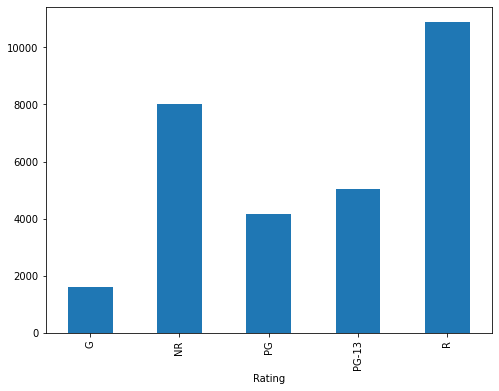

In [183]:
fig = plt.figure(figsize=(8,6))
dataset_df.groupby('Rating')['cleanedDescr'].count().plot.bar(ylim=0)
plt.show()

## Use same amount of labels

In [184]:
PG_count = dataset_df[dataset_df.Rating == 'G'].shape
PG_count

(1606, 4)

In [185]:
dataset_df = dataset_df.sample(frac=1).groupby('Rating').head(1606)
dataset_df

,Title,Rating,Description,cleanedDescr
8897,El Bao del Papa (The Pope's Toilet),NR,Uruguayan directors Csar Chalone and Enrique F...,Uruguayan directors Csar Chalone and Enrique F...
18451,The Two of Us (Le vieil homme et l'enfant),R,Having been forced into minor parts for severa...,Having been forced into minor parts for severa...
26788,Killing Me Softly,R,The director of such highly regarded films as ...,The director of such highly regarded films as ...
26499,Vertige (High Lane),NR,Gallic helmer Abel Ferry (not to be confused w...,Gallic helmer Abel Ferry not to be confused wi...
13991,45 Years,R,There is just one week until Kate Mercer's for...,There is just one week until Kate Mercer forty...
...,...,...,...,...
18217,Mr. Skeffington,G,"Whose face ravaged, grotesque is in the mirror...",Whose face ravaged grotesque is in the mirror ...
2038,Rockers,G,"In this film, Larry ""Horsemouth"" Walker, who h...",In this film Larry Horsemouth Walker who has b...
1348,Yellow Submarine,G,Yellow Submarine is an animated meandering jou...,Yellow Submarine is an animated meandering jou...
28296,Pete's Dragon,G,Based on a story by Hollywood old-timers Seton...,Based on story by Hollywood old timers Seton M...


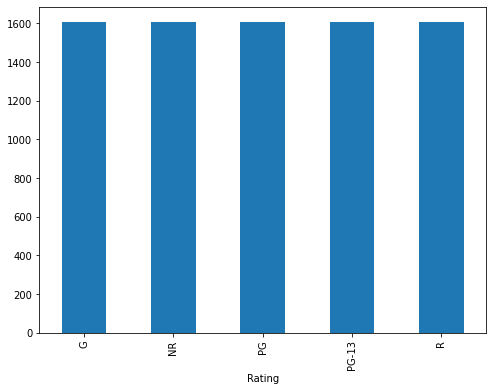

In [186]:
fig = plt.figure(figsize=(8,6))
dataset_df.groupby('Rating')['cleanedDescr'].count().plot.bar(ylim=0)
plt.show()

## Training model

In [187]:
training_df = pickle.load( open('./data/dataset_df_cleaned_n_sample_exceptNC17BiD.pkl', 'rb') )

In [188]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, LSTM, Embedding, GlobalMaxPooling1D, Bidirectional

In [134]:
_y = training_df['Rating']
encoder = LabelEncoder()
Y = encoder.fit_transform(_y)
Y

array([4, 4, 4, ..., 5, 4, 4])

In [189]:
X = training_df['cleanedDescr']
X

0        The Fast and the Furious director Rob Cohen co...
1        The journey of professional wrestler who becom...
2        Dead pan Leslie Nielsen stars as Dick Steele a...
3        Director Uli Edel teams with screenwriter Bern...
4        One of cluster of late films about the Vietnam...
                               ...                        
29805    Filmed at least nine times over the last nine ...
29806    Fred MacMurray stars in this Walt Disney comed...
29807    A resident of rd century Earth becomes involve...
29808    Supernova chronicles the search and rescue pat...
29809    For years there have been documented cases of ...
Name: cleanedDescr, Length: 29810, dtype: object

In [191]:
description_lengths = []
for i, description in training_df['cleanedDescr'].iteritems():
    description_lengths.append( len(description) )
max_description_length = np.mean( description_lengths )
max_description_length

729.3683998658169

## Train, test split

In [192]:
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.3, random_state=40 )

In [193]:
Y_train = to_categorical(Y_train)
Y_test  = to_categorical(Y_test)

In [194]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

In [195]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test  = tokenizer.texts_to_sequences(X_test)

In [196]:
vocabulary_size = len(tokenizer.word_index) + 1
vocabulary_size

56359

In [197]:
max_description_length = 400
maxlen =  400 # Only concider first 400 words of each description

X_train = pad_sequences( X_train, maxlen=maxlen )
X_test  = pad_sequences( X_test, maxlen=maxlen )

## Use GloVe : Global Vectors for Word Representation
https://nlp.stanford.edu/projects/glove/

GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space. 

In [198]:
glove_file = open('./glove.6B/glove.6B.100d.txt', encoding='utf8')

In [199]:
embedd_dictionary = dict()
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dims = np.asarray(records[1:], dtype='float32')
    embedd_dictionary[word] = vector_dims

glove_file.close()

In [200]:
embedd_matrix = np.zeros((vocabulary_size, 100))
for word, index in tokenizer.word_index.items():
    embedd_vector = embedd_dictionary.get(word)
    if embedd_vector is not None:
        embedd_matrix[index] = embedd_vector
        
output_dim = embedd_matrix.shape[1]
output_dim

100

## Build the NN Model

In [210]:
model = Sequential()
model.add(Embedding(input_dim=vocabulary_size, output_dim=output_dim, weights=[embedd_matrix], trainable=False))
model.add( Bidirectional(LSTM(units=256, dropout=0.4, recurrent_dropout=0)) )
#model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0) )
#model.add(Dense(64, activation='softmax'))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, None, 100)         5635900   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 512)               731136    
_________________________________________________________________
dense_31 (Dense)             (None, 6)                 3078      
Total params: 6,370,114
Trainable params: 734,214
Non-trainable params: 5,635,900
_________________________________________________________________


In [211]:
import keras
callback = [
    #keras.callbacks.EarlyStopping(patience=2),
    keras.callbacks.ModelCheckpoint(filepath='./data/checkpoint/model.{epoch:02d}-{val_loss:.2f}.h5'),
    keras.callbacks.TensorBoard(log_dir='.data/tf/logs'),
]

In [212]:
hist = model.fit(X_train, Y_train, batch_size=128, epochs=100, validation_split=0.20, verbose=1, callbacks=callback)

Epoch 1/100
131/131 [==============================] - 15s 98ms/step - loss: 1.4883 - accuracy: 0.3639 - val_loss: 1.4094 - val_accuracy: 0.3999
Epoch 2/100
131/131 [==============================] - 12s 90ms/step - loss: 1.3999 - accuracy: 0.4041 - val_loss: 1.4011 - val_accuracy: 0.3991
Epoch 3/100
131/131 [==============================] - 12s 91ms/step - loss: 1.3911 - accuracy: 0.4179 - val_loss: 1.3130 - val_accuracy: 0.4363
Epoch 4/100
131/131 [==============================] - 12s 92ms/step - loss: 1.2924 - accuracy: 0.4561 - val_loss: 1.2461 - val_accuracy: 0.4835
Epoch 5/100
131/131 [==============================] - 12s 92ms/step - loss: 1.2617 - accuracy: 0.4764 - val_loss: 1.2649 - val_accuracy: 0.4681
Epoch 6/100
131/131 [==============================] - 12s 93ms/step - loss: 1.2249 - accuracy: 0.4952 - val_loss: 1.1952 - val_accuracy: 0.4962
Epoch 7/100
131/131 [==============================] - 12s 94ms/step - loss: 1.1881 - accuracy: 0.5104 - val_loss: 1.1675 - val_ac

131/131 [==============================] - 12s 91ms/step - loss: 0.1321 - accuracy: 0.9556 - val_loss: 1.0815 - val_accuracy: 0.7676
Epoch 58/100
131/131 [==============================] - 12s 91ms/step - loss: 0.1397 - accuracy: 0.9510 - val_loss: 1.0784 - val_accuracy: 0.7583
Epoch 59/100
131/131 [==============================] - 12s 91ms/step - loss: 0.1315 - accuracy: 0.9544 - val_loss: 1.0985 - val_accuracy: 0.7659
Epoch 60/100
131/131 [==============================] - 12s 94ms/step - loss: 0.1392 - accuracy: 0.9535 - val_loss: 1.0784 - val_accuracy: 0.7604
Epoch 61/100
131/131 [==============================] - 12s 94ms/step - loss: 0.1352 - accuracy: 0.9532 - val_loss: 1.1388 - val_accuracy: 0.7611
Epoch 62/100
131/131 [==============================] - 12s 94ms/step - loss: 0.1515 - accuracy: 0.9460 - val_loss: 1.1183 - val_accuracy: 0.7643
Epoch 63/100
131/131 [==============================] - 13s 96ms/step - loss: 0.1259 - accuracy: 0.9573 - val_loss: 1.1489 - val_accuracy

In [213]:
loss, acc = model.evaluate(X_test, Y_test, verbose=1)
print('loss: ', loss)
print('accuracy: ', acc)

280/280 [==============================] - 6s 22ms/step - loss: 1.2483 - accuracy: 0.7585
loss:  1.248302936553955
accuracy:  0.7584702968597412


## Save model and tokenizer

In [214]:
# save model
model.save('./data/mpaa_classifier_n_sample_exceptNC17BiD.h5')

# save word tokenizer
pickle.dump(tokenizer, open('./data/tokenizer_n_sample_exceptNC17BiD.pkl', 'wb'))

## Metrics

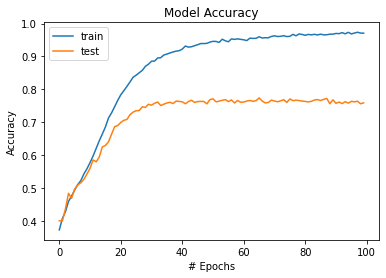

In [215]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('# Epochs')
plt.legend(['train', 'test'])
plt.show()

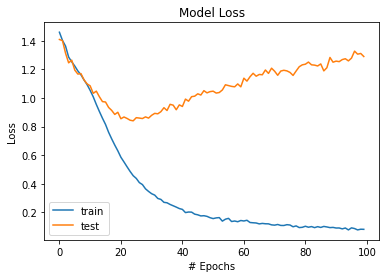

In [216]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('# Epochs')
plt.legend(['train', 'test'])
plt.show()

## Model Architecture

In [ ]:
# load the saved model
from keras.models import load_model
model = load_model("./data/mpaa_classifier_n_sample_exceptNC17BiD.h5")

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Demonstration